<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/Geoscience/Reproduction%EF%BC%9A_Physics_informed_neural_networks_applied_to_catastrophic_creeping_landslides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [2]:
# Define the network architecture
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x



In [10]:
# Create synthetic data for training and validation
np.random.seed(0)
N = 1000  # number of samples
z = np.random.normal(0, 1, N)
t = np.random.normal(0, 1, N)
Gr = np.random.normal(0, 1, N)
temp = 2*z + 3*t + 5*Gr + np.random.normal(0, 0.1, N)  # assuming a linear relationship for this example

X = np.column_stack([z, t, Gr])
y = temp

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
Gr_tensor = torch.tensor(Gr, dtype=torch.float32)

In [11]:
# Define the model
model = PINN()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5000):
    # Forward pass
    outputs = model(X_train_tensor)
    # Compute the loss
    mse_loss = nn.MSELoss()(outputs, y_train_tensor.view(-1, 1))
    pde_loss = (outputs[1:] - outputs[:-1] - Gr_tensor[:-1]*torch.exp(outputs[:-1])).pow(2).mean()
    loss = mse_loss + pde_loss
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{5000}, Loss: {loss.item()}')


Epoch 1000/5000, Loss: 24.39649772644043
Epoch 2000/5000, Loss: 24.309412002563477
Epoch 3000/5000, Loss: 24.213420867919922
Epoch 4000/5000, Loss: 23.958995819091797
Epoch 5000/5000, Loss: 23.647506713867188


In [12]:
# Validation
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
outputs = model(X_val_tensor)
val_loss = nn.MSELoss()(outputs, y_val_tensor.view(-1, 1))
print(f'Validation Loss: {val_loss.item()}')

Validation Loss: 21.27521324157715


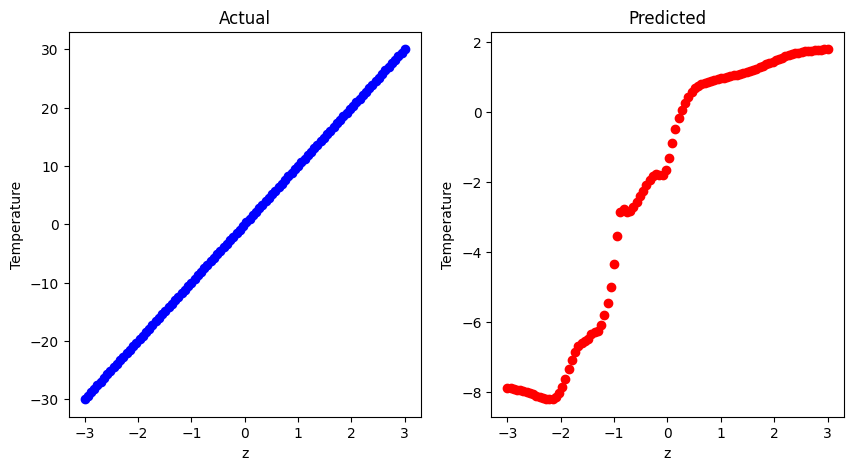

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Test
X_test = np.column_stack([np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), np.linspace(-3, 3, 100)])
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = 2*X_test[:, 0] + 3*X_test[:, 1] + 5*X_test[:, 2]  # actual
y_test_tensor = model(X_test_tensor).detach().numpy()  # predicted

# Visualize
plt.figure(figsize=(10, 5))

# Plot actual data
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], y_test, color='blue')
plt.title('Actual')
plt.xlabel('z')
plt.ylabel('Temperature')

# Plot predicted data
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], y_test_tensor, color='red')
plt.title('Predicted')
plt.xlabel('z')
plt.ylabel('Temperature')

plt.show()


## The synthetic data was generated by using the observations from Segui et al. ([2020](https://link.springer.com/article/10.1007/s10346-023-02072-0#ref-CR50 "Segui C, Rattez H, Veveakis M (2020) On the stability of deep-seated landslides. The cases of Vaiont (Italy) and Shuping (Three Gorges Dam, China). J Geophys Res Earth Surf 125(7):e2019JF005203")) and Veveakis et al. ([2007](https://link.springer.com/article/10.1007/s10346-023-02072-0#ref-CR57 "Veveakis E, Vardoulakis I, Di Toro G (2007) Thermoporomechanics of creeping landslides: the 1963 Vaiont slide, Northern Italy. J Geophys Res Earth Surf 112(F3)")). Those studies show that the Gruntfest number follows a sinusoidal wavy, increasing, pattern. This sinusoidal pattern is related to seasonal groundwater variation, which leads to an increase in the temperature of the shear band, and an acceleration of the sliding mass (Cecinato et al. [2008](https://link.springer.com/article/10.1007/s10346-023-02072-0#ref-CR13 "Cecinato F, Zervos A, Veveakis E et al (2008) Numerical modelling of the thermo-mechanical behaviour of soils in catastrophic landslides. Landslides and Engineered Slopes. Two Volumes+ CD-ROM. CRC Press, From the Past to the Future, pp 637–644"); Seguí et al. [2021](https://link.springer.com/article/10.1007/s10346-023-02072-0#ref-CR51 "Seguí C, Tauler E, Planas X et al (2021) The interplay between phyllosilicates fabric and mechanical response of deep-seated landslides. The case of El forn de canillo landslide (Andorra). Landslides 18(1):145–160")). This behavior can be mathematically expressed as follows:

$$
G r=0.8 t+\exp (t)(0.07 \sin (c * t)) 0<t<1
$$

In [14]:
import numpy as np

# Constants
c = 32

# Time array
t = np.linspace(0, 1, 1000)

# Calculate Gruntfest number
Gr = 0.8 * t + np.exp(t) * (0.07 * np.sin(c * t))

# Generate synthetic temperature data using some hypothetical function
# For the purpose of this demonstration, let's assume the temperature is proportional to the Gruntfest number
# Please replace this with the actual method for calculating temperature if available
temp = Gr

# Generate z data (depth below the ground surface).
# For simplicity, let's assume it's a constant value. In reality, you might have a more complex relationship.
z = np.ones_like(t) * 0.5

# Combine the data
synthetic_data = np.column_stack([z, t, Gr, temp])

synthetic_data[:5]  # Show the first 5 rows of the synthetic data


array([[0.5       , 0.        , 0.        , 0.        ],
       [0.5       , 0.001001  , 0.0030449 , 0.0030449 ],
       [0.5       , 0.002002  , 0.006092  , 0.006092  ],
       [0.5       , 0.003003  , 0.00913898, 0.00913898],
       [0.5       , 0.004004  , 0.01218354, 0.01218354]])

In [15]:
synthetic_data

array([[0.5       , 0.        , 0.        , 0.        ],
       [0.5       , 0.001001  , 0.0030449 , 0.0030449 ],
       [0.5       , 0.002002  , 0.006092  , 0.006092  ],
       ...,
       [0.5       , 0.997998  , 0.89275707, 0.89275707],
       [0.5       , 0.998999  , 0.8988871 , 0.8988871 ],
       [0.5       , 1.        , 0.90492532, 0.90492532]])

In [16]:
# Convert the synthetic data into tensors
X_train_tensor = torch.tensor(synthetic_data[:, :3], dtype=torch.float32)
y_train_tensor = torch.tensor(synthetic_data[:, 3], dtype=torch.float32).view(-1, 1)

# Set the number of epochs and the learning rate
epochs = 5000
learning_rate = 0.001

# Define the model
model = PINN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)




In [17]:
# Training loop
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    # Compute the loss
    mse_loss = criterion(outputs, y_train_tensor)
    pde_loss = (outputs[1:] - outputs[:-1] - X_train_tensor[:-1, 2]*torch.exp(outputs[:-1])).pow(2).mean()
    loss = mse_loss + pde_loss
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print the loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1000/5000, Loss: 0.366652250289917
Epoch 2000/5000, Loss: 0.36664292216300964
Epoch 3000/5000, Loss: 0.366630494594574
Epoch 4000/5000, Loss: 0.3666267991065979
Epoch 5000/5000, Loss: 0.3666107952594757


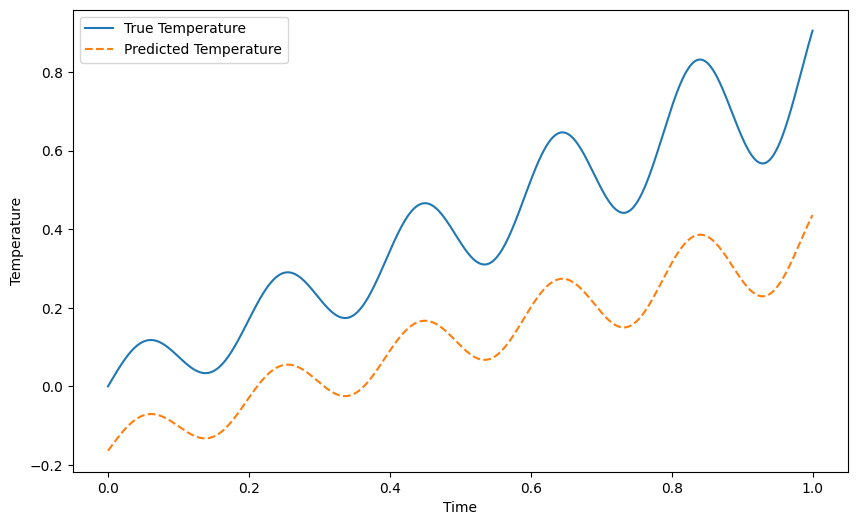

In [18]:
# Compute model predictions
y_pred = model(X_train_tensor).detach().numpy()

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(t, synthetic_data[:, 3], label='True Temperature')
plt.plot(t, y_pred, '--', label='Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()